In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import gzip
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.prediction_algorithms import SVD, knns, KNNWithMeans, KNNBasic, KNNBaseline, KNNWithZScore, CoClustering, BaselineOnly, NormalPredictor, NMF, SVDpp, SlopeOne
from surprise.model_selection import GridSearchCV, RandomizedSearchCV
import numpy as np
import seaborn as sns

# Retreive the data and create DataFrames for the files

In [2]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [3]:
data_test = parse('australian_user_reviews.json.gz')

In [4]:
data_test

<generator object parse at 0x7fd709e2c0b0>

In [5]:
full_data = parse('steam_reviews.json.gz')

In [6]:
full_data

<generator object parse at 0x7fd709e2c3c0>

In [7]:
game_data = parse('steam_games.json.gz')

In [8]:
game_data

<generator object parse at 0x7fd709e2c6d0>

In [9]:
item_data = parse('australian_users_items.json.gz')

In [10]:
test_df = pd.DataFrame(data_test)

In [11]:
game_df = pd.DataFrame(game_data)

In [12]:
item_df = pd.DataFrame(item_data)

In [13]:
test_df.head()

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."


In [14]:
game_df.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [15]:
item_df.head()

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."


# Data Cleaning

This saves all of the game ids a user has into a 2d list - this will be used to save the info for the rec system

In [16]:
all_game_id = []
for ids in item_df['items']:
    temp_list = []
    for count in range(len(ids)):
        #print(ids[count]['item_id'])
        temp_list.append(int(ids[count]['item_id']))
    #print(temp_list)
    all_game_id.append(temp_list)
    #print(len(ids))

In [17]:
len(all_game_id[1])

888

In [18]:
item_df['game_ids'] = all_game_id

In [19]:
item_df.head()

,user_id,items_count,steam_id,user_url,items,game_ids
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik...","[10, 20, 30, 40, 50, 60, 70, 130, 300, 240, 38..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik...","[10, 80, 100, 300, 30, 40, 60, 240, 280, 360, ..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest...","[1200, 1230, 1280, 1520, 220, 320, 340, 360, 3..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik...","[10, 20, 30, 40, 50, 60, 70, 130, 80, 100, 300..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea...","[300, 20, 50, 70, 130, 10, 30, 40, 60, 80, 100..."


Create a new column called user_ids to replace the old user id

In [20]:
item_df['user_ids'] = item_df.index

In [21]:
item_df.head()

,user_id,items_count,steam_id,user_url,items,game_ids,user_ids
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik...","[10, 20, 30, 40, 50, 60, 70, 130, 300, 240, 38...",0
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik...","[10, 80, 100, 300, 30, 40, 60, 240, 280, 360, ...",1
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest...","[1200, 1230, 1280, 1520, 220, 320, 340, 360, 3...",2
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik...","[10, 20, 30, 40, 50, 60, 70, 130, 80, 100, 300...",3
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea...","[300, 20, 50, 70, 130, 10, 30, 40, 60, 80, 100...",4


This makes it so the game id explodes and saves the user id to the game they have played

In [22]:
game_df = game_df.rename(columns={'id':'game_ids'})

In [23]:
clean_df = item_df[['user_ids','game_ids']]

In [24]:
clean_df = clean_df.explode('game_ids')

In [25]:
clean_df.reset_index(inplace=True,drop=True)

In [26]:
clean_df

,user_ids,game_ids
0,0,10
1,0,20
2,0,30
3,0,40
4,0,50
...,...,...
5170010,88308,373330
5170011,88308,388490
5170012,88308,521570
5170013,88308,519140


Creates a new df of game_df to allow for merging the DataFrames together

In [27]:
new_game_df = game_df[['app_name','game_ids','title']]

In [28]:
new_game_df = new_game_df[new_game_df['game_ids'].notna()]

Change the game_ids to int so merging can match the values properly

In [29]:
new_game_df=new_game_df.astype({'game_ids':'int'})

Merge the DataFrames

In [30]:
merged_df = clean_df.merge(new_game_df,how='inner',on=['game_ids'])

In [31]:
clean_df=merged_df[['user_ids','game_ids']]

In [32]:
clean_df['game_ids'].isna().sum()

0

In [33]:
clean_df['owned'] = 1

<ipython-input-33-58837cf90a8d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['owned'] = 1


In [34]:
clean_df

,user_ids,game_ids,owned
0,0,10,1
1,1,10,1
2,3,10,1
3,4,10,1
4,10,10,1
...,...,...,...
4294252,74089,375450,1
4294253,85030,353390,1
4294254,86026,354280,1
4294255,86588,433920,1


# EDA

Lets see how many unique users there are

In [35]:
len(set(clean_df['user_ids']))

69304

Now lets check how many unique games there are

In [36]:
len(set(clean_df['game_ids']))

9192

Here is the top 10 most owned games

<AxesSubplot:>

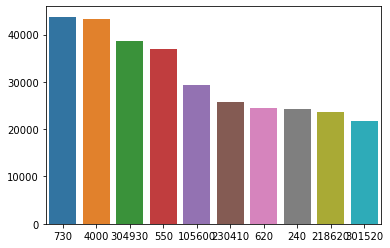

In [37]:
sns.barplot(x = clean_df['game_ids'].value_counts().index[0:10], y = clean_df['game_ids'].value_counts().values[0:10],order=clean_df['game_ids'].value_counts().index[0:10])

Now lets see the top 10 users who own the most amount of games

<AxesSubplot:>

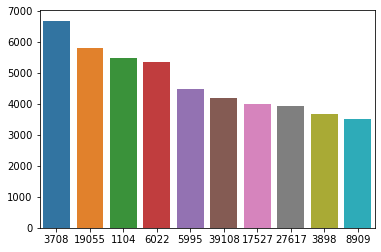

In [38]:
sns.barplot(x = clean_df['user_ids'].value_counts().index[0:10], y = clean_df['user_ids'].value_counts().values[0:10],order=clean_df['user_ids'].value_counts().index[0:10])

Here we convert string dates into datetime values so we can perform EDA on them

In [39]:
dates = pd.to_datetime(game_df['release_date'],errors='coerce')

In [40]:
dates.dropna(inplace=True)

In [41]:
dates.head()

0   2018-01-04
1   2018-01-04
2   2017-07-24
3   2017-12-07
5   2018-01-04
Name: release_date, dtype: datetime64[ns]

Lets see how many games were sold during each month

In [42]:
month_holder =[]
for date in dates:
    month_holder.append(date.month)

In [43]:
month_series = pd.Series(month_holder)

<AxesSubplot:>

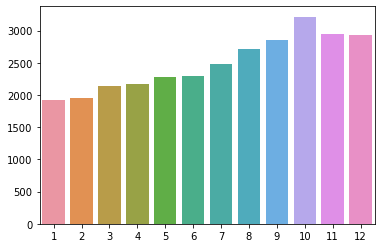

In [44]:
sns.barplot(x = month_series.value_counts().index,y=month_series.value_counts().values)

Now lets do the same, but for years

In [45]:
year_holder =[]
for date in dates:
    year_holder.append(date.year)
year_series = pd.Series(year_holder)

<AxesSubplot:xlabel='release_date', ylabel='Count'>

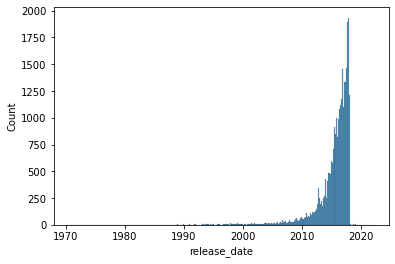

In [46]:
sns.histplot(dates)

<AxesSubplot:>

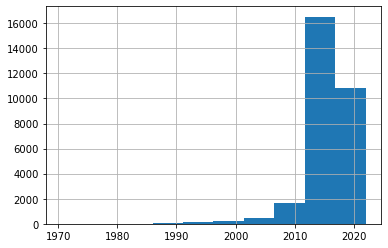

In [47]:
dates.hist()

Finally, lets see how each quarter of the year performs

In [48]:
quarter_holder =[]
for date in dates:
    quarter_holder.append(date.quarter)
quarter_series = pd.Series(quarter_holder)

<AxesSubplot:>

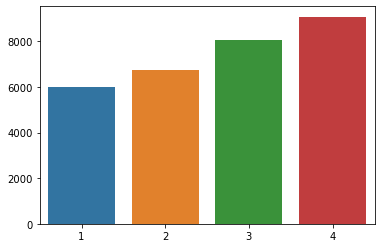

In [49]:
sns.barplot(x = quarter_series.value_counts().index,y=quarter_series.value_counts().values)

[Text(0, 0, 'Ubisoft - San Francisco'),
 Text(1, 0, 'SmiteWorks USA, LLC'),
 Text(2, 0, 'Dovetail Games'),
 Text(3, 0, 'KOEI TECMO GAMES CO., LTD.'),
 Text(4, 0, 'Paradox Development Studio'),
 Text(5, 0, 'Capcom'),
 Text(6, 0, 'Ronimo Games'),
 Text(7, 0, 'Choice of Games'),
 Text(8, 0, 'Musopia'),
 Text(9, 0, 'Stainless Games'),
 Text(10, 0, 'N3V Games'),
 Text(11, 0, 'Ubisoft Montreal'),
 Text(12, 0, 'Relic Entertainment,Feral Interactive (Mac),Feral Interactive (Linux)'),
 Text(13, 0, 'DL Softworks'),
 Text(14, 0, 'SCS Software'),
 Text(15, 0, 'Milestone S.r.l.'),
 Text(16, 0, 'Team NINJA,KOEI TECMO GAMES CO., LTD.'),
 Text(17, 0, 'Arc System Works'),
 Text(18, 0, 'Infinity Ward'),
 Text(19, 0, 'Rebellion')]

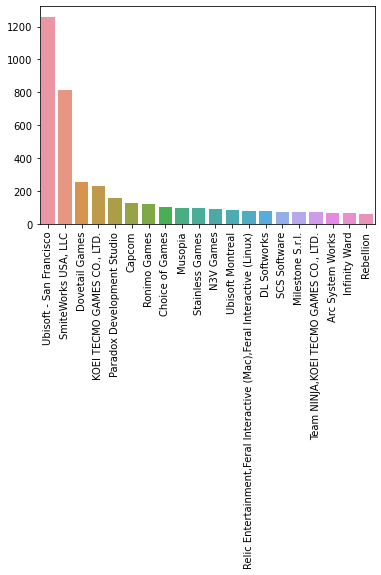

In [76]:
developers = sns.barplot(x=game_df['developer'].value_counts().index[0:20],y=game_df['developer'].value_counts().values[0:20])
developers.set_xticklabels(labels =game_df['developer'].value_counts().index[0:20], rotation=90)

Lets check out the prices

/Users/jakeash/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

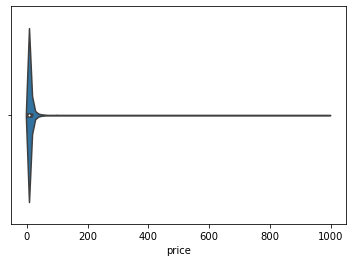

In [51]:
game_df['price'].value_counts()
#sns.barplot(x=game_df['price'].value_counts().index[0:10],y=game_df['price'].value_counts().values[0:10])
f = game_df['price'].apply(lambda x:x if type(x)==float else np.nan)
sns.violinplot(f.dropna())

Well, that didn't help much!

Finally, lets see how many games users own

<AxesSubplot:>

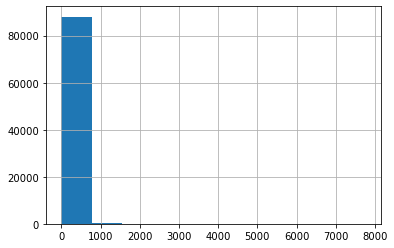

In [52]:
item_df['items_count'].hist()
#sns.histplot(item_df['items_count'])

### Making the df include the zeros

In [48]:
clean_df_pivot = clean_df.pivot(index=['user_ids'],columns=['game_ids'],values='owned')

In [49]:
clean_df_pivot = clean_df_pivot.fillna(0)

In [50]:
clean_df_pivot

game_ids,10,20,30,40,50,60,70,80,130,220,...,527440,527510,527520,527810,527890,527900,528580,528660,529820,530720
user_ids,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
clean_df_melt = clean_df_pivot.melt(var_name='game_ids', value_name='owned',ignore_index=False)

In [52]:
clean_df_melt

,game_ids,owned
user_ids,,
0,10,1.0
1,10,1.0
2,10,0.0
3,10,1.0
4,10,1.0
...,...,...
88303,530720,0.0
88304,530720,0.0
88305,530720,0.0


In [54]:
clean_df_melt.index.value_counts()

88277    9192
26420    9192
26437    9192
26436    9192
26443    9192
         ... 
53727    9192
53726    9192
53721    9192
53720    9192
0        9192
Name: user_ids, Length: 69304, dtype: int64

In [56]:
clean_df_melt.reset_index(inplace=True)

In [57]:
clean_df_melt

,user_ids,game_ids,owned
0,0,10,1.0
1,1,10,1.0
2,2,10,0.0
3,3,10,1.0
4,4,10,1.0
...,...,...,...
637042363,88303,530720,0.0
637042364,88304,530720,0.0
637042365,88305,530720,0.0
637042366,88306,530720,0.0


# Modeling

## Load the data into Dataset so Surprise can run

In [53]:
reader = Reader(rating_scale=(0,1))
data = Dataset.load_from_df(clean_df,reader)

In [54]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  69304 

Number of items:  9192


## BaselineOnly Models

### BaselineOnly ALS Model

In [55]:
als = cross_validate(BaselineOnly(bsl_options={'method':'als'}), data, cv=5, verbose=True, n_jobs=-1)
als

Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
MAE (testset)     0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
Fit time          3.06    3.60    2.92    1.89    2.21    2.74    0.61    
Test time         8.16    6.87    6.54    6.23    5.06    6.57    1.00    


{'test_rmse': array([0., 0., 0., 0., 0.]),
 'test_mae': array([0., 0., 0., 0., 0.]),
 'fit_time': (3.0565268993377686,
  3.6014339923858643,
  2.923646926879883,
  1.894843339920044,
  2.2128870487213135),
 'test_time': (8.155605792999268,
  6.870700120925903,
  6.538866758346558,
  6.231442213058472,
  5.064397811889648)}

### BaselineOnly SGD model

In [56]:
sgd = cross_validate(BaselineOnly(bsl_options={'method':'sgd'}), data, cv=5, verbose=True, n_jobs=-1)
sgd

Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
MAE (testset)     0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
Fit time          7.24    8.75    7.77    7.11    6.01    7.38    0.89    
Test time         13.14   9.96    7.18    6.51    5.09    8.38    2.86    


{'test_rmse': array([0., 0., 0., 0., 0.]),
 'test_mae': array([0., 0., 0., 0., 0.]),
 'fit_time': (7.240863800048828,
  8.752906084060669,
  7.767884016036987,
  7.108551979064941,
  6.012972116470337),
 'test_time': (13.138061761856079,
  9.958091974258423,
  7.1825501918792725,
  6.512453079223633,
  5.0904381275177)}

## NMF model

In [57]:
nmf = cross_validate(NMF(random_state=22), data, cv=5, verbose=True, n_jobs=-1)
nmf

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0596  0.0597  0.0596  0.0597  0.0596  0.0596  0.0000  
MAE (testset)     0.0595  0.0596  0.0595  0.0596  0.0595  0.0596  0.0000  
Fit time          234.54  234.16  237.88  234.13  232.83  234.71  1.69    
Test time         10.26   11.62   10.66   8.87    8.53    9.99    1.15    


{'test_rmse': array([0.05963771, 0.05966501, 0.05962103, 0.05969086, 0.05963351]),
 'test_mae': array([0.05954084, 0.05956883, 0.05952387, 0.05958408, 0.05953763]),
 'fit_time': (234.54386830329895,
  234.16381001472473,
  237.88387799263,
  234.13367819786072,
  232.83060789108276),
 'test_time': (10.260680198669434,
  11.618790864944458,
  10.658957242965698,
  8.865646123886108,
  8.526763916015625)}

## Normal Predictor Model

In [58]:
normal_pred = cross_validate(NormalPredictor(), data, cv=5, verbose=True, n_jobs=-1)
normal_pred

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
MAE (testset)     0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
Fit time          3.39    3.52    4.17    3.26    3.20    3.51    0.35    
Test time         9.08    10.61   8.72    7.07    5.75    8.25    1.68    


{'test_rmse': array([0., 0., 0., 0., 0.]),
 'test_mae': array([0., 0., 0., 0., 0.]),
 'fit_time': (3.386715888977051,
  3.524768114089966,
  4.174357891082764,
  3.256925344467163,
  3.1964569091796875),
 'test_time': (9.082302808761597,
  10.613451957702637,
  8.716604232788086,
  7.066136121749878,
  5.750547170639038)}

## Co Clustering Model

In [59]:
co_clustering = cross_validate(CoClustering(random_state=22), data, cv=5, verbose=True, n_jobs=-1)
co_clustering

Evaluating RMSE, MAE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
MAE (testset)     0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
Fit time          96.15   102.70  108.28  104.89  96.78   101.76  4.68    
Test time         11.24   11.62   17.97   9.20    7.03    11.41   3.66    


{'test_rmse': array([0., 0., 0., 0., 0.]),
 'test_mae': array([0., 0., 0., 0., 0.]),
 'fit_time': (96.14821195602417,
  102.69652605056763,
  108.27522802352905,
  104.88746905326843,
  96.77681803703308),
 'test_time': (11.237172842025757,
  11.617352962493896,
  17.966703176498413,
  9.204142093658447,
  7.026132822036743)}

## Slope One Model

In [61]:
slope_one = cross_validate(SlopeOne(), data, cv=5, verbose=True, n_jobs=-1)
slope_one

Evaluating RMSE, MAE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
MAE (testset)     0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
Fit time          111.80  117.40  122.62  123.84  119.22  118.98  4.26    
Test time         738.81  770.57  785.92  785.52  783.80  772.93  17.97   


{'test_rmse': array([0., 0., 0., 0., 0.]),
 'test_mae': array([0., 0., 0., 0., 0.]),
 'fit_time': (111.8027229309082,
  117.40138483047485,
  122.61568903923035,
  123.83688712120056,
  119.22172284126282),
 'test_time': (738.8074929714203,
  770.5717368125916,
  785.9236128330231,
  785.5207641124725,
  783.8035840988159)}

## SVD++ Model

SVD++ is the SVD model, but also takes implicit data into account. This is extremely helpful because of how our data is set up where it only has 1's, no 0's.

In [78]:
svdpp = cross_validate(SVDpp(random_state=22), data, cv=5, verbose=True, n_jobs=-1)
svdpp

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0039  0.0039  0.0039  0.0039  0.0039  0.0039  0.0000  
MAE (testset)     0.0009  0.0009  0.0009  0.0009  0.0009  0.0009  0.0000  
Fit time          12665.9312536.1912476.9212698.3312673.0712610.0987.26   
Test time         153.17  187.77  190.31  138.55  143.46  162.65  22.07   


{'test_rmse': array([0.00388142, 0.00388078, 0.00388067, 0.00393282, 0.00389222]),
 'test_mae': array([0.00094466, 0.00092904, 0.00093587, 0.00093797, 0.0009329 ]),
 'fit_time': (12665.92928814888,
  12536.187048196793,
  12476.915660142899,
  12698.331763982773,
  12673.07183790207),
 'test_time': (153.16672110557556,
  187.77393317222595,
  190.31450009346008,
  138.54910588264465,
  143.45506119728088)}

# Model selection

Looking at the results, we can see 2 things. First off, BaselineOnly, Slope One, NormalPredictor and Co Clustering were all scoring zeros. This is how the data is saved, so we cannot use those values.  As we can see, out of SVD SVD++ and NMF, SVD++ gives us the best model. This is what we will use for our final model

## Hyper parameter tuning

Here we use Randomized Search CV to find the best results. _WARNING: Running this will take multiple days to complete. This model has not finished running, so hyper parameter tuning will not be utilized at this time._

In [80]:
# params = {'n_factors': [20],
#          'reg_all': [0.02, 0.1],
#          'lr_all': [0.005, 0.01]}
# g_s_svdpp = RandomizedSearchCV(SVDpp,param_distributions=params,n_jobs=-1,joblib_verbose=4,cv=2,measures=['rmse','mae'])
# g_s_svdpp.fit(data)

Lets look at the top 50 most owned games to pick values for our new user

In [62]:
merged_df['game_ids'].value_counts().head(50)

730       43776
4000      43301
304930    38682
550       37044
105600    29239
230410    25807
620       24465
240       24220
218620    23729
301520    21785
49520     21029
218230    20726
340       19826
227940    19721
400       18774
220       18307
236390    18172
333930    17233
208090    16489
8190      16272
252490    16201
224260    15979
219640    15930
320       15854
322330    15571
8930      15303
24240     15202
33930     15084
55230     14753
1250      14216
35420     14000
304050    13969
360       13327
380       13275
22380     13131
420       13060
42910     12239
200210    12105
8870      11967
252950    11605
204360    11511
113200    11400
222880    11368
221100    10923
17410     10846
291480    10794
265630    10723
407530    10493
323370    10484
291550    10322
Name: game_ids, dtype: int64

# Predictions

Create a new user using 4 random games from the list above of the top 50 most popular games

In [66]:
#CS: GO, Left for Dead 2, Borderlands 2, PAYDAY 2, Warframe
user_play = [{'user_ids': 100000, 'game_ids': 730, 'owned': 1},
 {'user_ids': 100000, 'game_ids': 550, 'owned': 1},
 {'user_ids': 100000, 'game_ids': 49520, 'owned': 1},
 {'user_ids': 100000, 'game_ids': 218620, 'owned': 1},
 {'user_ids': 100000, 'game_ids': 230410, 'owned': 1}]
#Binding of Isaac 113200 super meat boy 40800 ori and the blind forest 261570 Broforce 274190 Geometry Dash 322170 SpeedRunners 207140

Add the new user to the dataset

In [67]:
new_games_df = clean_df.append(user_play,ignore_index=True)
new_data = Dataset.load_from_df(new_games_df,reader)

Lets run the default SVD++ model on the full trainset

In [68]:
svdpp_ = SVDpp()
svdpp_.fit(new_data.build_full_trainset())

Loop through all of the games and make predictions on those games for the new user

In [69]:
list_of_games = []
for g_id in clean_df['game_ids'].unique():
    list_of_games.append((g_id,svdpp_.predict(100000,g_id)[3]))

In [70]:
game_pred = sorted(list_of_games, key=lambda x:x[1], reverse=True)

A function that predicts new recommendations for the user

In [71]:
def recommended_games(user_play,game_title_df,n):
        for idx, rec in enumerate(user_play):
            title = game_title_df.loc[game_title_df['game_ids'] == int(rec[0])]['app_name']
            first_title = title.iloc[0]
            print('Recommendation # ', idx+1, ': ', first_title, '\n')
            n-= 1
            if n == 0:
                break

Lets see the recommendations!

In [74]:
recommended_games(game_pred,merged_df,10)

Recommendation #  1 :  Team Fortress Classic 

Recommendation #  2 :  Day of Defeat 

Recommendation #  3 :  Day of Defeat: Source 

Recommendation #  4 :  Psychonauts 

Recommendation #  5 :  Sid Meier's Pirates! 

Recommendation #  6 :  Joint Task Force 

Recommendation #  7 :  Deus Ex: Game of the Year Edition 

Recommendation #  8 :  Half-Life 2 

Recommendation #  9 :  Medieval II: Total War™ 

Recommendation #  10 :  AudioSurf 

